# Unsupervised Machine Learning Techniques Assignment I - RY2464

**Objective:**
- Use two PyOD methods - PCA and KNNs. You can find the PCA and KNNs method in the PyOD module.Links to an external site.
- Explain what PCA and KNNs are
- analysis of why identify providers as anomalous.

## Table of Content
1. [Preliminary Set Up](#Section_1)
2. [EDA](#Section_2)
3. [PCA](#Section_3)
4. [KNN](#Section_4)

## 1. Preliminary Set Up <a class="anchor" id="Section_1"></a>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pyod
from sklearn.model_selection import train_test_split
import plotly
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('inpatientCharges.csv')

In [3]:
df.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']
df.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


- **Total discharges**: The number of discharges billed by the provider for inpatient hospital services. When you leave a hospital after treatment, you go through a process called hospital discharge.

- **Covered Charges**: Charges for covered services that your health plan paid for. There may be a limit on covered charges if you receive services from providers outside your plan's network of providers. Covered Person - Any person covered under the plan. Covered Service - A healthcare provider’s service or medical supplies covered by your health plan. Benefits will be given for these services based on your plan.

- **Total Covered Charge Amount** = the sum of all covered charges

- **Average Covered Charges** = Total Covered Charge Amount / Total Discharges

- Payment is the amount a hospital actually receives for providing patient care. This is the actual amount paid to a hospital by consumers, insurers or governments. The sources of payment are: 
    1. Medicare and Medicaid 
    2. Private insurer if any
    3. The Patient

- **Average Total Payments** = Total Payments / Total Discharges

- **Average Medicare Payments** = Medicare Payment Amount / Total Discharges

### Converting Columns into the correct datatype

In [4]:
df['DRG'] = df['DRG'].astype('category')
df['Provider_State'] = df['Provider_State'].astype('category')
df['Provider_City'] = df['Provider_City'].astype('category')
df['Provider_Id'] = df['Provider_Id'].astype('category')
df['Provider_Zipcode'] = df['Provider_Zipcode'].astype('category')

df['Average_Covered_Charges'] = (df['Average_Covered_Charges']
                              .str.replace(r'[^-+\d.]', '').astype(float))

df['Average_Total_Payments'] = (df['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
df['Average_Medicare_Payment'] = (df['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))
df['Medicare_Per']=df['Average_Medicare_Payment']/df['Average_Total_Payments'] # percentage covered by medicare

In [5]:
df.describe()

,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Medicare_Per
count,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000
mean,42.776304,36133.954224,9707.473804,8494.490964,0.846545
std,51.104042,35065.365931,7664.642598,7309.467261,0.087911
min,11.000000,2459.400000,2673.000000,1148.900000,0.043155
25%,17.000000,15947.160000,5234.500000,4192.350000,0.796634
50%,27.000000,25245.820000,7214.100000,6158.460000,0.860189
75%,49.000000,43232.590000,11286.400000,10056.880000,0.913504
max,3383.000000,929118.900000,156158.180000,154620.810000,1.000000


## 2. Features<a class="anchor" id="Section_2"></a>
1. Ratio of Provider's median Average Total Payment within a DRG relative to Referral Group Median
2. Ratio of Provider's median Average Total Medicare Payment within a DRG relative to Referral Group Median
3. Ratio of Provider's median Average Total Medicare Payment within a DRG relative to State Median
4. Ratio of Provider's median Average Total Payment within a DRG relative to State Median
5. Ratio of Total Discharges comparing to national median within DRG group
6. Ratio of Patient out-of-pocket payment comparing to state and DRG median
7. Ratio of Provider's Efficency (Total Payments/Total Covered Charges) relative to DRG and State Median
8. Ratio of Provider's Discharge_to_Payment_Ratio (Total Discharges/Total Payments) Relative to DRG and State Median


I believe selecting the above features give us insight on comparing metrics that highlight deviation between individual provider behaviors and broader benchmarks within specific Diagnosis Related Groups, referral groups, state medians, and national averages. Significant deviation from multiple benchmark can hint potential abuse or fraud practice.

for this, I am going to load the dataframe with all the features added in previous homework, and take out features interested.

In [6]:
df1 = pd.read_csv('inpatient_with_features.csv')
#drop irrelevant column
df1=df1[['DRG', 'Provider_Id', 'Provider_Name',
       'Provider_StreetAddress', 'Provider_City', 'Provider_State',
       'Provider_Zipcode', 'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Covered_Charges', 'Average_Total_Payments','Average_Medicare_Payment',
       'TC_to_DRG_reg_Median_Ratio', 'TC_to_DRG_reg_medi_Ratio',
       'Medicare_Payment_Ratio','TC_to_DRG_ST_Median_Ratio','Discharge_to_National_Median_Ratio',
       'st_Patient_Pay_Ratio', 'Cost_Efficiency','st_Discharge_to_Payment_Ratio']]

       
df1.columns = [['DRG', 'Provider_Id', 'Provider_Name',
       'Provider_StreetAddress', 'Provider_City', 'Provider_State',
       'Provider_Zipcode', 'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Covered_Charges', 'Average_Total_Payments','Average_Medicare_Payment',
       'TC_to_DRG_ref_Median_Ratio','MC_to_DRG_ref_Median_Ratio',
       'MC_to_DRG_st_Median_Ratio','TC_to_DRG_st_Median_Ratio','Discharge_to_National_Median_Ratio',
       'Patient_Pay_st_DRG_Ratio', 'Cost_Efficiency_st_DRG_Ratio','Discharge_to_Payment_st_Ratio']]

In [7]:
df1.describe()

,Provider_Id,Provider_Zipcode,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,TC_to_DRG_ref_Median_Ratio,MC_to_DRG_ref_Median_Ratio,MC_to_DRG_st_Median_Ratio,TC_to_DRG_st_Median_Ratio,Discharge_to_National_Median_Ratio,Patient_Pay_st_DRG_Ratio,Cost_Efficiency_st_DRG_Ratio,Discharge_to_Payment_st_Ratio
count,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304,36133.954224,9707.473804,8494.490964,1.036331,1.038494,1.055484,1.050746,1.288741,1.137393,0.334889,1.190795
std,151563.671767,27854.323080,51.104042,35065.365931,7664.642598,7309.467261,0.179935,0.196388,0.234139,0.211465,1.017942,0.665172,0.177397,0.856414
min,10001.000000,1040.000000,11.000000,2459.400000,2673.000000,1148.900000,0.416786,0.331728,0.367836,0.517695,0.105769,0.000000,0.042346,0.016142
25%,110092.000000,27261.000000,17.000000,15947.160000,5234.500000,4192.350000,0.942559,0.935187,0.916191,0.925511,0.666667,0.821175,0.215690,0.656856
50%,250007.000000,44309.000000,27.000000,25245.820000,7214.100000,6158.460000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.297683,1.000000
75%,380075.000000,72901.000000,49.000000,43232.590000,11286.400000,10056.880000,1.076226,1.082952,1.121178,1.112126,1.583333,1.241161,0.403780,1.466556
max,670077.000000,99835.000000,3383.000000,929118.900000,156158.180000,154620.810000,8.618473,5.733904,6.030981,9.338775,74.809524,19.385306,5.207929,21.961239


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   (DRG,)                                 163065 non-null  object 
 1   (Provider_Id,)                         163065 non-null  int64  
 2   (Provider_Name,)                       163065 non-null  object 
 3   (Provider_StreetAddress,)              163065 non-null  object 
 4   (Provider_City,)                       163065 non-null  object 
 5   (Provider_State,)                      163065 non-null  object 
 6   (Provider_Zipcode,)                    163065 non-null  int64  
 7   (Hospital_referral_region_desp,)       163065 non-null  object 
 8   (Total_Discharges,)                    163065 non-null  int64  
 9   (Average_Covered_Charges,)             163065 non-null  float64
 10  (Average_Total_Payments,)              163065 non-null  

In [ ]:
df1.head()

## 3. PCA - Principal Component Analysis  <a class="anchor" id="Section_1"></a>

- A statistical technique used for exploratory data analysis and simplifying datasets by reducing their dimensionality.
- It transforms the data to a new axis by identifying the directions (principal components) that maximize variance, aiding in visualization, noise reduction, and improving algorithm performance.

By transforms forming data through PCA can make anomalies in the dataset stand out clearly. Outliers may not be obvious in the original high-dimensional space due to the complex relationships between variables, by rotating the axis we are able to pick out outliers easily.


Before conducting the PCA, I will first standardize my features using sklearn

In [9]:
pca_df = df1[['TC_to_DRG_ref_Median_Ratio','MC_to_DRG_ref_Median_Ratio',
       'MC_to_DRG_st_Median_Ratio','TC_to_DRG_st_Median_Ratio','Discharge_to_National_Median_Ratio',
       'Patient_Pay_st_DRG_Ratio', 'Cost_Efficiency_st_DRG_Ratio','Discharge_to_Payment_st_Ratio']]

Before applying the PCA, I will first standardize the dataset

In [10]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
pca_df = scaler.fit_transform(pca_df) 

In [11]:
pca_df

array([[ 0.00821892,  0.00136676,  0.04196922, ..., -0.28034661,
        -0.89982194, -1.03785172],
       [-0.41204664, -0.39339268, -0.29760404, ..., -0.26753711,
        -1.12547052, -0.72937638],
       [ 0.04534141,  0.37907393,  0.24539035, ..., -0.56823101,
         0.26825048,  0.90551662],
       ...,
       [ 0.10634968, -0.2452158 , -0.31872255, ..., -0.20655352,
         0.11082618, -0.12189235],
       [-0.5101774 , -0.14681012, -0.23697312, ..., -0.78096829,
        -0.19189286, -0.53902904],
       [-0.20191386, -0.19601296,  0.29682447, ...,  0.36004276,
         0.53348487, -0.22278376]])

In [12]:
from pyod.models.pca import PCA
pca = PCA(contamination=0.05) 
pca.fit(pca_df)

PCA(contamination=0.05, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [13]:
# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(pca_df) # You also can use .decision_function()
y_train_pred = pca.predict(pca_df) # You also can use .decision_function()


In [14]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [15]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([3.57604561, 1.53467855, 1.08601836, 0.95211056, 0.4161588 ,
        0.30635117, 0.11400139, 0.01468463]),
 array([0.44700296, 0.19183364, 0.13575146, 0.11901309, 0.05201953,
        0.03829366, 0.01425009, 0.00183557])]


The PCA variance explained indicates that the first principal component accounts for approximately 44.7% of the variance in the dataset, highlighting its significant role in capturing the data's underlying structure. The second and third components explain an additional 19.2% and 13.6% of the variance, respectively, suggesting that together, these top three components capture the majority of the dataset's variability, while the remaining components contribute progressively less, indicating diminishing returns on information gained.

In [16]:
print("The threshold for 5% comtanimation rate:" , pca.threshold_)

The threshold for 5% comtanimation rate: 3688.1231895196292


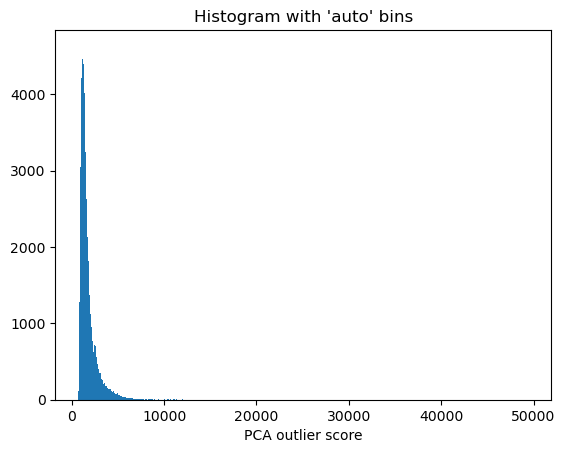

In [17]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

In [18]:
threshold = pca.threshold_
threshold

def descriptive_stat_threshold(df,pred_score, threshold):
    # Grouping observation in to Normal and Outliers
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(pca_df,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,Anomaly_Score
0,Normal,154911,94.99954,-0.12,-0.11,-0.11,-0.12,-0.03,-0.04,-0.04,-0.06,1574.21
1,Outlier,8154,5.00046,2.25,2.05,2.14,2.36,0.50,0.68,0.79,1.23,5124.41


The PCA results indicate that providers identified as outliers exhibit significantly distinct patterns across the PCs compared to result of data. The higher mean values in components 0 through 3 for the providers in outlier group suggest that these components are capturing aspects of the data where these providers differ substantially from the norm. This could reflect atypical billing practices, unusual patient care ratios, or other operational characteristics that are outliers compared to standard healthcare provider behavior. The considerably elevated anomaly scores for these providers serve as a quantitative measure of their deviation from the established patterns within the dataset, thus flagging them for further investigation which may reveal inefficiencies, billing inconsistencies, or even fraudulent activities.

## 4. KNN <a class="anchor" id="Section_4"></a>
- KNN is a non-parametric algorithm used in both unsupervised and supervised learning for classification and regression.
- it predicts and labels data points by looking at its 'k' closest labeled data points, taking a majority vote or average

We can use KNN for fraud detection in healthcare analytics by analyzing the selected features for each provider and identifying those whose feature patterns significantly deviate from their neighbors. As outliers in this feature space may represent fraudulent activities, the proximity-based approach of KNN will flag providers with anomalous billing or operational practices when they don't cluster with the majority of other data points.

In [19]:
knn_df = df1[['TC_to_DRG_ref_Median_Ratio','MC_to_DRG_ref_Median_Ratio',
       'MC_to_DRG_st_Median_Ratio','TC_to_DRG_st_Median_Ratio','Discharge_to_National_Median_Ratio',
       'Patient_Pay_st_DRG_Ratio', 'Cost_Efficiency_st_DRG_Ratio','Discharge_to_Payment_st_Ratio']]

knn_df = scaler.fit_transform(knn_df) 

In [20]:
from pyod.models.knn import KNN
knn = KNN(contamination=0.05) 
knn.fit(knn_df)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [21]:
# fitting it to the dataset
knn_scores = knn.decision_function(knn_df)
knn_pred = knn.predict(knn_df)

In [22]:
# Training data
knn_scores = knn.decision_function(knn_df)
knn_pred = knn.predict(knn_df)

In [23]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(knn_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The training data: {0: 155821, 1: 7244}
The threshold for the defined comtanimation rate: 0.8400571052587505


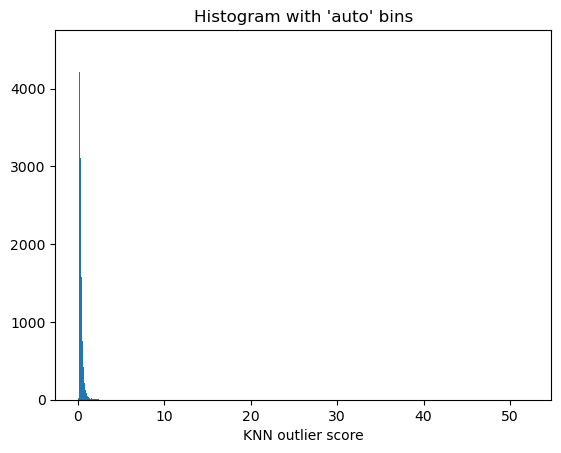

In [24]:
#bullding a histogram showing the outlier score
plt.hist(knn_scores, bins='auto')  
plt.title("Histogram with 'auto' bins")
plt.xlabel('KNN outlier score')
plt.show()

In [26]:

threshold = knn.threshold_
def descriptive_stat_threshold(df,pred_score, threshold):
    # distinguish the normal and outliers by the threshold
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(knn_df,knn_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,Anomaly_Score
0,Normal,155821,95.5576,-0.07,-0.05,-0.06,-0.09,-0.01,-0.07,-0.04,-0.06,0.36
1,Outlier,7244,4.4424,1.60,1.05,1.27,1.87,0.28,1.44,0.82,1.28,1.29


The mean anomaly score for the outliers is significantly higher than for the normal group, indicating that KNN has effectively identified a subset of data points that diverge from the typical patterns found within the selected healthcare features. The high anomaly scores associated with the outliers indicate that these data points are relatively isolated from their neighbors. This isolation could correspond to irregularities or unusual patterns in billing, treatment, and operational practices within the healthcare data.

Given these results, the identified outliers should be further investigated. They could represent potential fraudulent behavior, such as billing for services not provided or overcharging, or they could be legitimate anomalies, such as rare medical cases or data entry errors. Therefore, while KNN has provided a useful initial filter for potential fraud detection, additional analysis and contextual inquiry are crucial to ascertain the true nature of these outliers in healthcare analytics.